<a href="https://colab.research.google.com/github/ItsCosmas/Traffic-Sign-Classification/blob/master/Traffic_Sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Clone* the *repository* containing the dataset into colab. This will allow access to the dataset inside this colab environment.

In [30]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

fatal: destination path 'german-traffic-signs' already exists and is not an empty directory.


In [31]:
!ls german-traffic-signs

signnames.csv  test.p  train.p	valid.p


The dataset is listed above: A *spreadsheet signnames.csv* and then *pickle files containing the train, test and validate* datasets.

Importing the Relevant Libraries

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical
from keras.layers import Dropout, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
import pickle
import pandas as pd
import random

In [0]:
np.random.seed(0)

*Unpickle* the Data to make it usable.

In [0]:
with open('german-traffic-signs/train.p', 'rb') as f:
  train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
  val_data = pickle.load(f)
with open('german-traffic-signs/test.p', 'rb') as f:
  test_data = pickle.load(f)
  
  
  
X_train , y_train = train_data['features'], train_data['labels']
X_val , y_val = val_data['features'], val_data['labels']
X_test , y_test = test_data['features'], test_data['labels']

We analyze the dataset to see how it looks like.

In [35]:
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(34799, 32, 32, 3)
(4410, 32, 32, 3)
(12630, 32, 32, 3)


*shape* gives us the number of *images*, *dimensions in pixels* and* depth*.
The Images have a depth of 3 because they're in **RGB** format and thus the depth 3 for each color channel.

Next We Assert The dataset to see if its correct

In [0]:
assert(X_train.shape[0] == y_train.shape[0]), "No. of Images is not equals to number of labels"
assert(X_val.shape[0] == y_val.shape[0]), "No. of Images is not equals to number of labels"
assert(X_test.shape[0] == y_test.shape[0]), "No. of Images is not equals to number of labels"

assert(x_train.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"
assert(x_val.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"
assert(x_test.shape[1:] == (32,32,3)), "The Dimesnsions of the images are not 32 x 32 x 3"

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


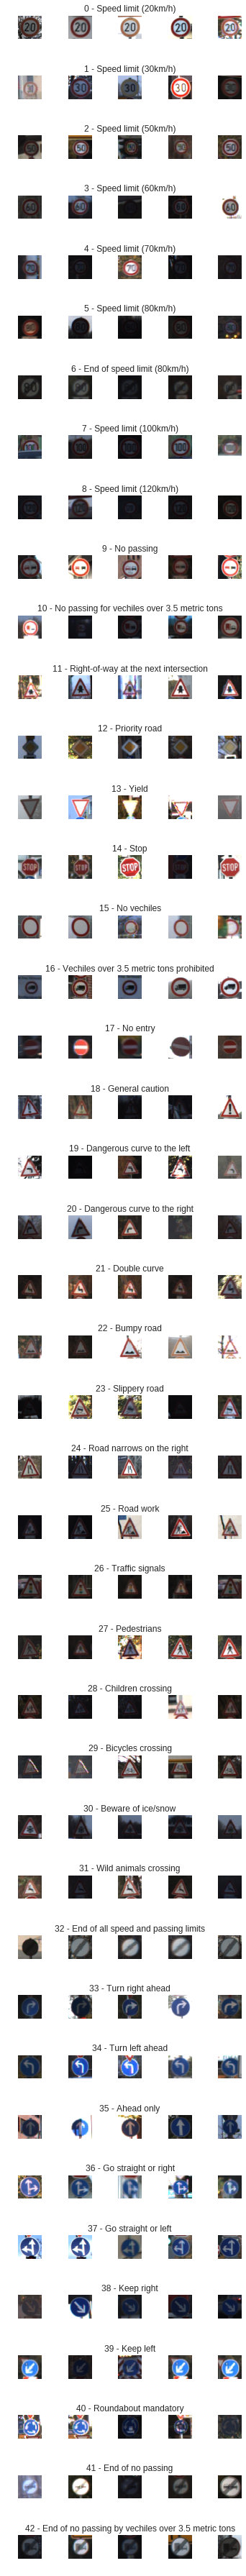

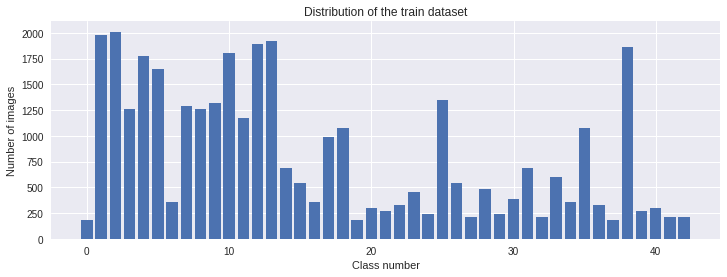

In [38]:
data = pd.read_csv('german-traffic-signs/signnames.csv')
#print(data)

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected))
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()